<h2>This notebook contains example code for the fine-tuning experiments</h2>
    
- In the main text, we trial over 10 random training seeds (one for each base model)
- This code currently uses 1 training seed, so graphs can be generated relatively quickly
- Dataset can be varied between dname='heloc' and dname='adult'
- Cells should be executed sequentially to avoid errors

In [2]:
from parser_utils import create_parser, process_args
from torch import nn
import torch
import neural_net
import training
import datasets
import numpy as np
import matplotlib.pyplot as plt
import os

# Parser

In [3]:
dname = 'heloc'  # or 'adult'

In [4]:
parser = create_parser()
args = parser.parse_args(args=[dname, 'data/' + dname, '--output_dir', f'models/{dname}_fine_tuning'])
args = process_args(args)
args

Namespace(dataset='heloc', file_base='data/heloc', dataset_shift=False, adversarial=False, output_dir='models/heloc_fine_tuning', label_col='label', linear=False, lr=0.2, lr_decay=None, epochs=20, batch_size=128, activation='relu', nodes_per_layer=50, num_layers=5, optimizer=None, loss=CrossEntropyLoss(), fixed_seed=False, target_indices=[], target_vals=[], indices_to_change=[], new_vals=[], threshold=0.0, strategy='random', epsilon=0.5, dropout=0.0)

In [5]:
output_dir = args.output_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_dir

'models/heloc_fine_tuning'

# Define Helper Functions and Parameters

In [12]:
def train_base(weight_decay, train_seed, epochs=200, lr=0.2, epsilon=0.2,
               activation=nn.ReLU(), adversarial=False, step_size=40, gamma=0.95):
    args.epochs = epochs
    args.lr = lr
    args.activation = activation
    perturb_params = datasets.PerturbParams(args.strategy, 0,
                                            args.target_indices, args.target_vals,
                                            args.indices_to_change, args.new_vals)
    scaler, scaler_labels = None, None
    train, test = datasets.load_data(args.file_base, args.dataset, scaler,
                                     scaler_labels, 0, perturb_params, noisy_test=False)
    num_feat, num_classes = train.num_features(), train.num_classes()
    params = training.Params(args.lr, args.lr_decay, args.epochs, args.batch_size,
                             loss_fn=args.loss, num_feat=num_feat,
                             num_classes=num_classes, activation=args.activation,
                             nodes_per_layer=args.nodes_per_layer, num_layers=args.num_layers,
                             optimizer=args.optimizer, seed=train_seed, epsilon=epsilon,
                             dropout=args.dropout, weight_decay=weight_decay,
                             step_size=step_size, gamma=gamma)
    base, acc_te, acc_tr, loss_te, loss_tr, pred, log, grad, _\
    = training.train_nn(params, train, test, args.dataset, plot=True,
                        print_terms=False, base=None, adversarial=adversarial)
    return base, acc_te, acc_tr, loss_te, loss_tr, pred, log, grad, params

In [13]:
def fine_tune(base, params, thresh, train_seed, noise_seed,
              epochs=100, adversarial=False, lr=0.05):
    perturb_params = datasets.PerturbParams(args.strategy, thresh,
                                            args.target_indices, args.target_vals,
                                            args.indices_to_change, args.new_vals)
    scaler, scaler_labels = None, None
    train, test = datasets.load_data(args.file_base, args.dataset, scaler,
                                     scaler_labels, noise_seed, perturb_params, noisy_test=False)
    # train, noisy_test = datasets.load_data(args.file_base, args.dataset, scaler,
    #                                  scaler_labels, noise_seed, perturb_params, noisy_test=True)
    #print("Noise:", np.linalg.norm(noisy_test.data-test.data))
    params.manual_seed = train_seed
    params.epochs = epochs
    params.learning_rate = lr
    model, acc_te, acc_tr, loss_te, loss_tr, pred, log, grad, weight_change\
    = training.train_nn(params, train, test, args.dataset, plot=True,
                        print_terms=False, base=base, adversarial=adversarial)
    return model, acc_te, acc_tr, loss_te, loss_tr, pred, log, grad, weight_change

In [14]:
perturb_params = datasets.PerturbParams(args.strategy, 0,
                                        args.target_indices, args.target_vals,
                                        args.indices_to_change, args.new_vals)
scaler, scaler_labels = None, None
train, test = datasets.load_data(args.file_base, args.dataset, scaler,
                                 scaler_labels, 0, perturb_params, noisy_test=False)

In [17]:
n_te, d = test.data.shape
n_te, d

(1975, 23)

# Curvature (Train Base Models)

In [18]:
wd = 0.001
acts = ['relu', 'soft', 'soft']
betas = [None, 5, 2]
activations = [nn.ReLU(), nn.Softplus(beta=betas[1]), nn.Softplus(beta=betas[2])]

In [19]:
step_size = 100
gamma = 0.95
base_epochs = 500
lr = 0.5
lr * gamma ** (base_epochs//step_size)

0.3868904687499999

#### Lightweight Version with One Training Seed

In [24]:
train_seeds = range(1)  # modify to range(10) to replicate paper results

Activation Function: ReLU()
Training with Seed 0


100%|█████████████████████████████████████████| 500/500 [01:47<00:00,  4.64it/s]


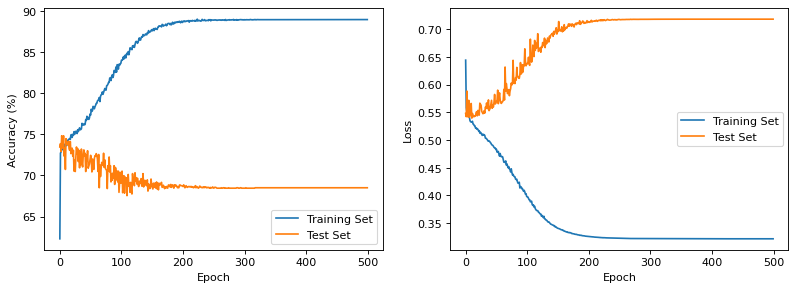

Activation Function: Softplus(beta=5, threshold=20)
Training with Seed 0


100%|█████████████████████████████████████████| 500/500 [01:53<00:00,  4.42it/s]


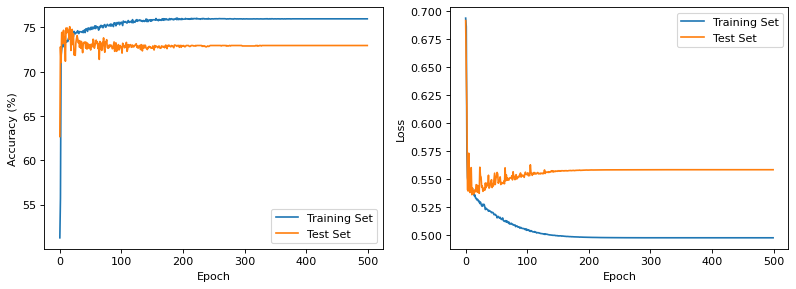

Activation Function: Softplus(beta=2, threshold=20)
Training with Seed 0


100%|█████████████████████████████████████████| 500/500 [01:50<00:00,  4.51it/s]


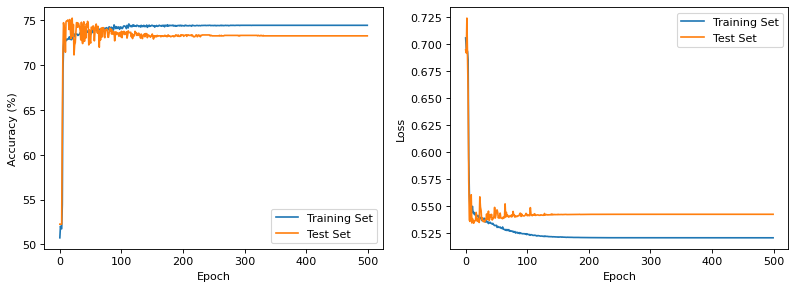

In [27]:
for i, act in enumerate(acts):
    b = str(betas[i]) if betas[i] is not None else ''
    print(f'Activation Function: {activations[i]}')
    for train_seed in train_seeds:
        base, acc_te, acc_tr, loss_te, loss_tr, pred, log, b_grads, params\
                    = train_base(weight_decay=wd, train_seed=train_seed, epochs=base_epochs,
                                 lr=lr, activation=activations[i], step_size=step_size, gamma=gamma)
        torch.save(base, output_dir+f'/base_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy')
        np.save(output_dir+f'/base_grads_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', b_grads)
        np.save(output_dir+f'/base_loss_te_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', loss_te)
        np.save(output_dir+f'/base_loss_tr_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy', loss_tr)

# Curvature (Fine-Tune Models under Dataset Shift - Synthetic Noise)

In [28]:
# Standard deviations for synthetic noise
thresholds = np.logspace(-3, -1, 10)
thresholds

array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])

In [29]:
ft_epochs = 50  # fine-tuning epochs
ft_lr = 0.01  # fine-tuning learning rate

0.001
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]


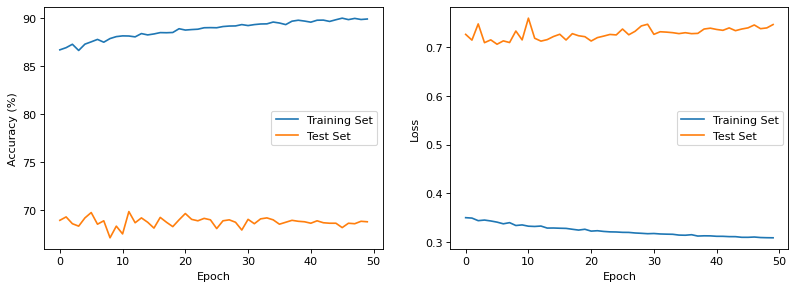

0.0016681005372000592
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.57it/s]


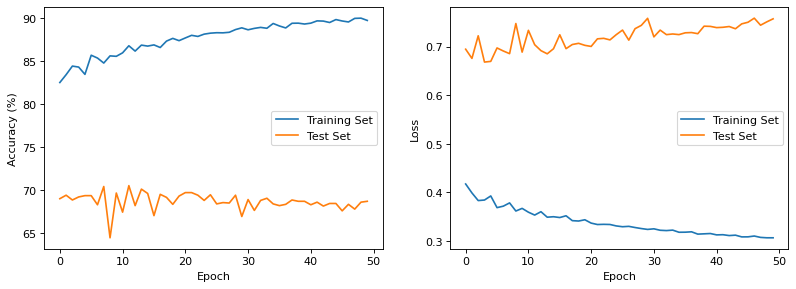

0.0027825594022071257
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.57it/s]


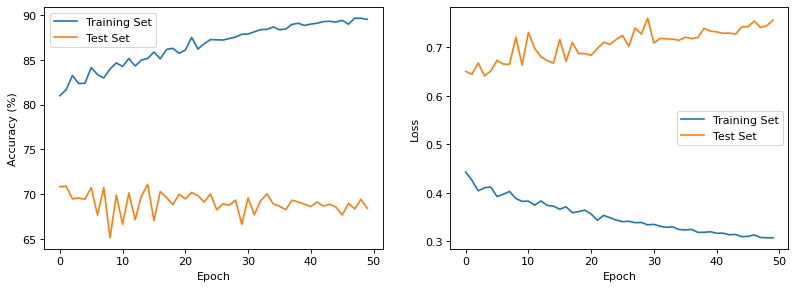

0.004641588833612777
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]


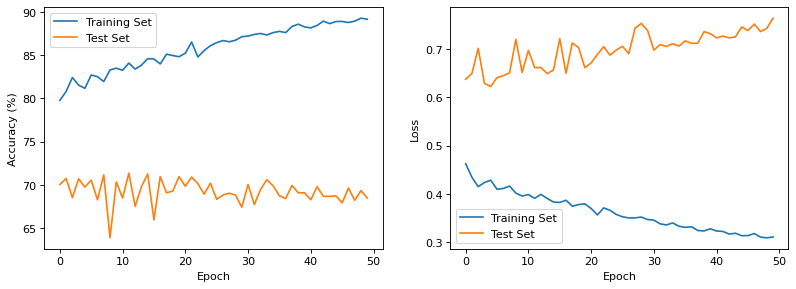

0.007742636826811269
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


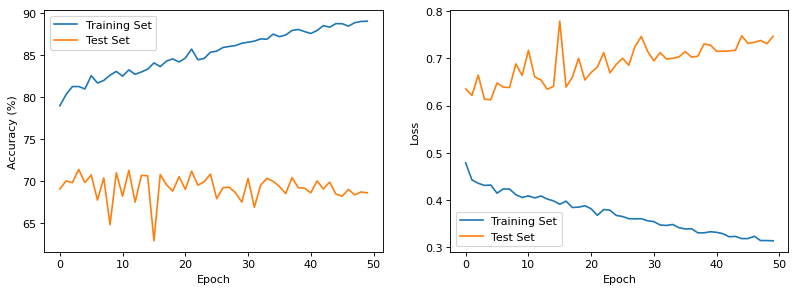

0.01291549665014884
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.55it/s]


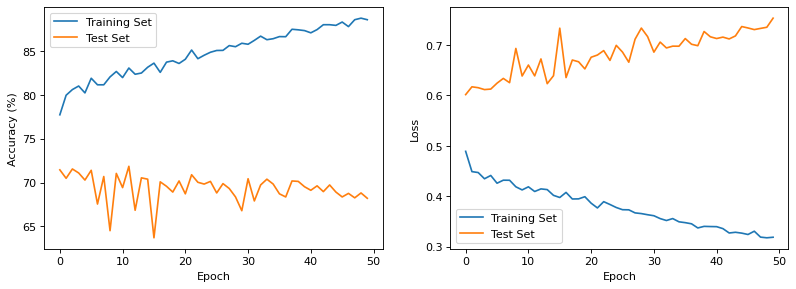

0.021544346900318832
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.63it/s]


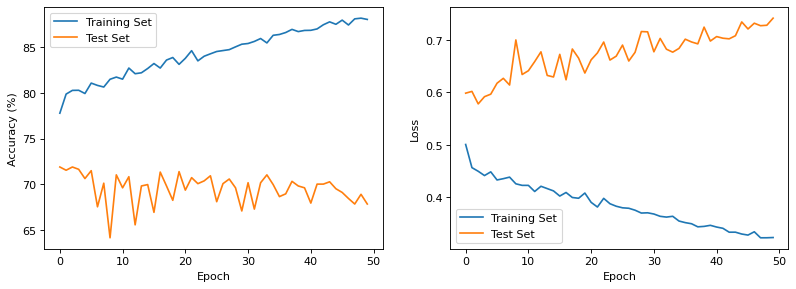

0.03593813663804626
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]


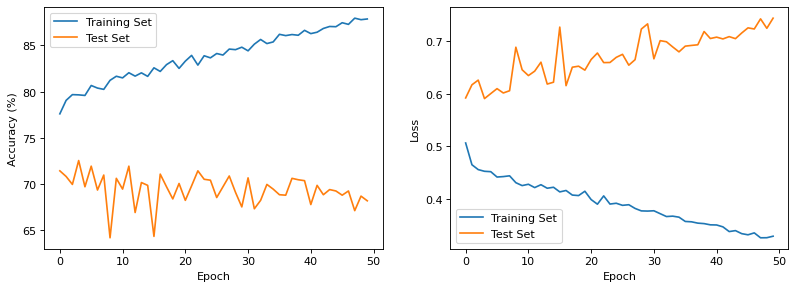

0.05994842503189409
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.44it/s]


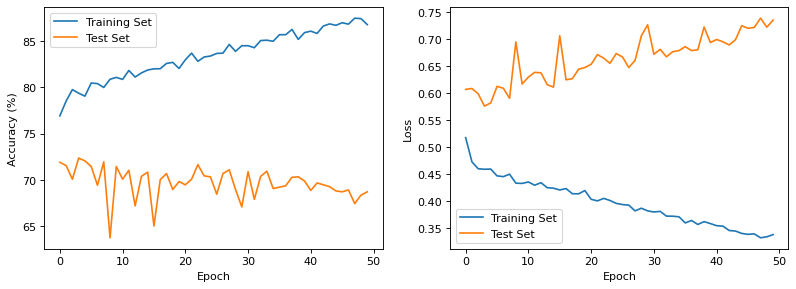

0.1
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


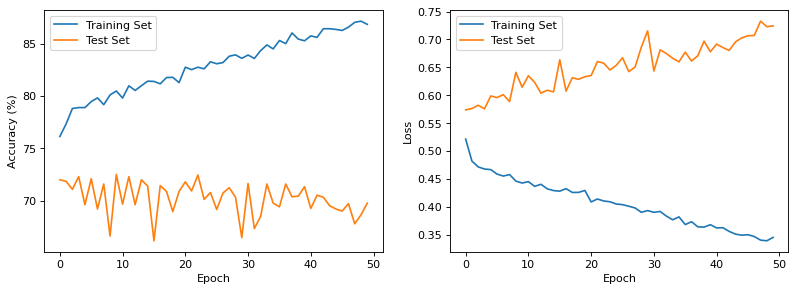

0.001
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.57it/s]


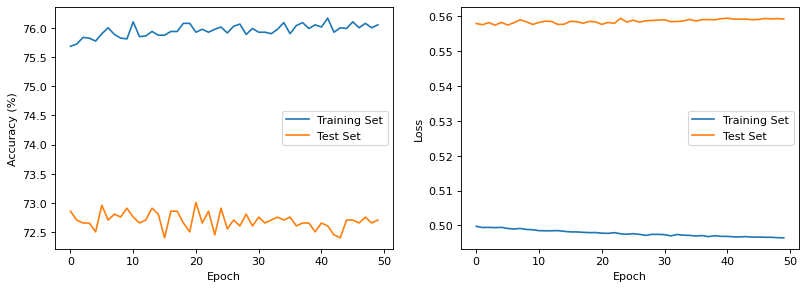

0.0016681005372000592
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.53it/s]


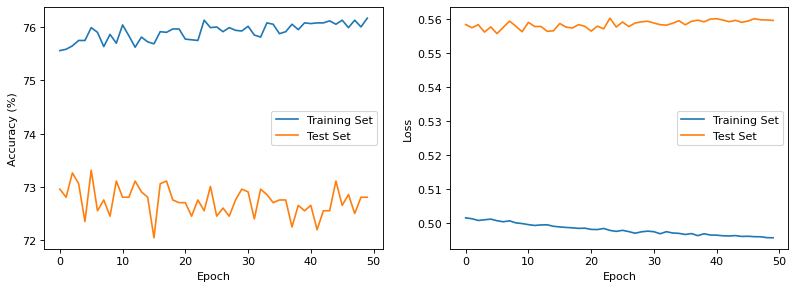

0.0027825594022071257
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.53it/s]


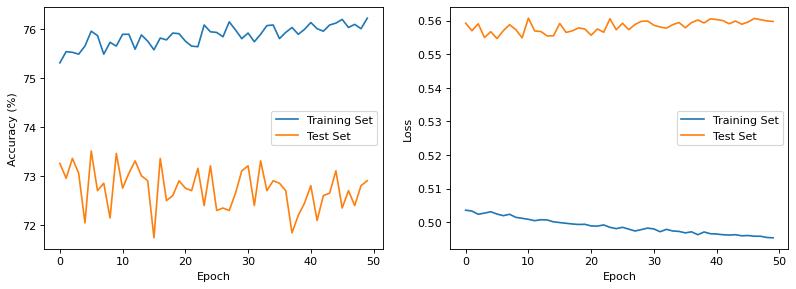

0.004641588833612777
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.27it/s]


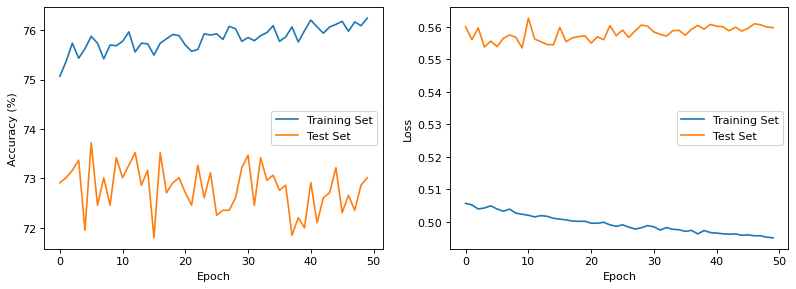

0.007742636826811269
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


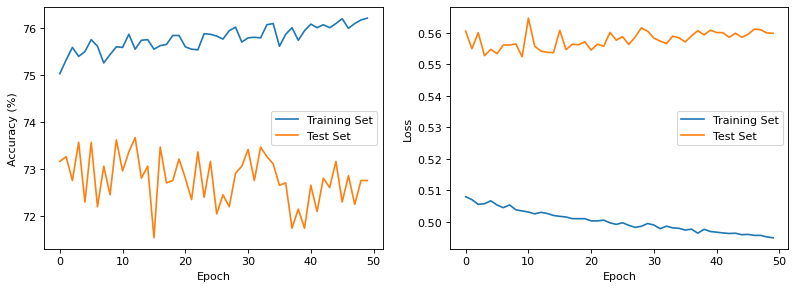

0.01291549665014884
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.47it/s]


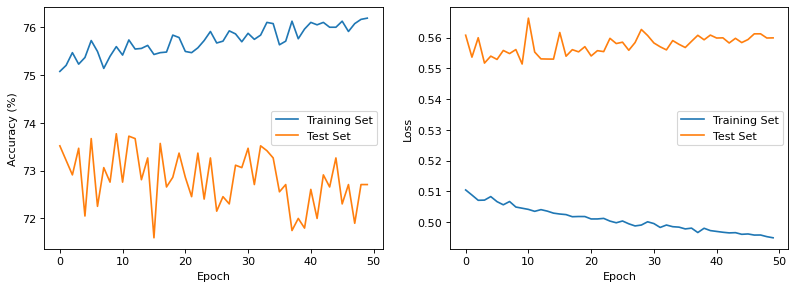

0.021544346900318832
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.54it/s]


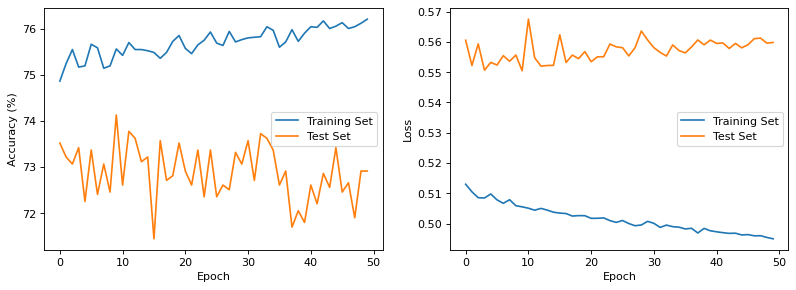

0.03593813663804626
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.47it/s]


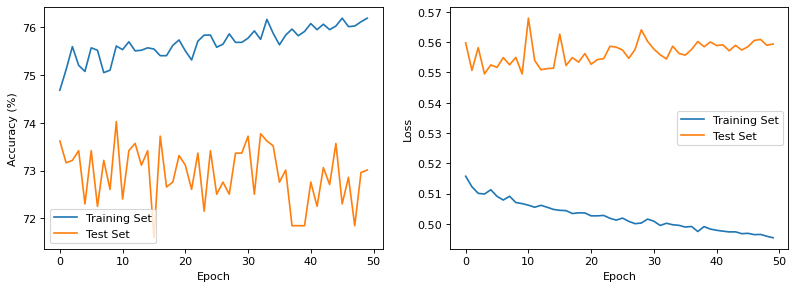

0.05994842503189409
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.48it/s]


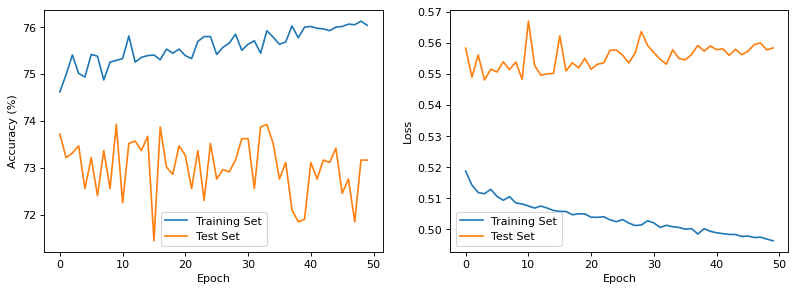

0.1
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.45it/s]


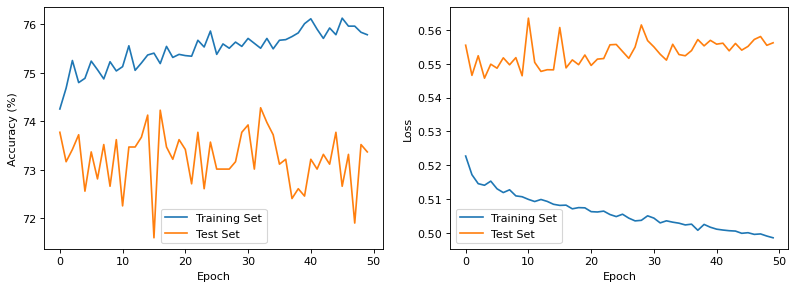

0.001
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.32it/s]


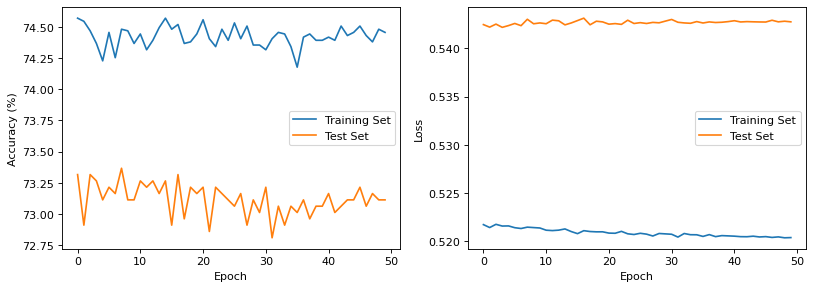

0.0016681005372000592
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.53it/s]


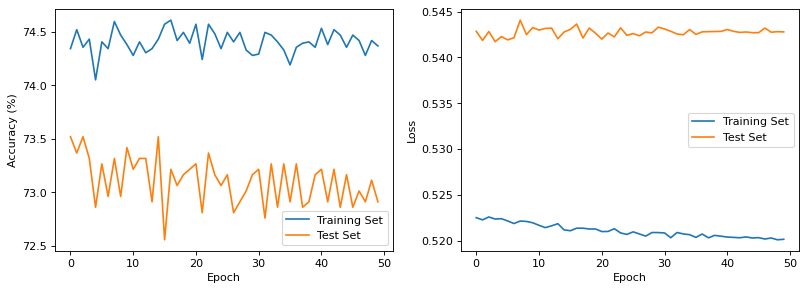

0.0027825594022071257
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.43it/s]


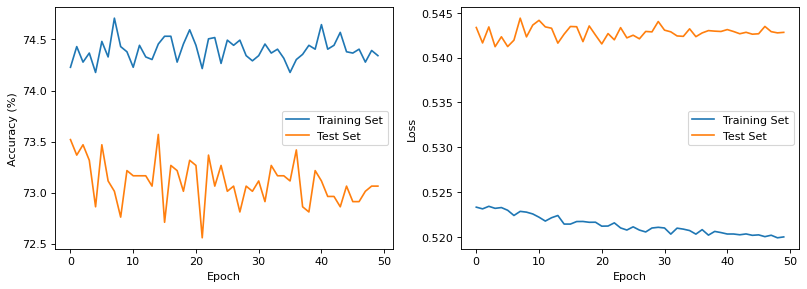

0.004641588833612777
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.18it/s]


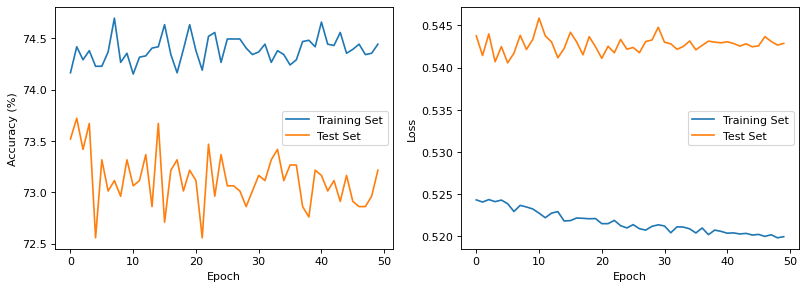

0.007742636826811269
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.28it/s]


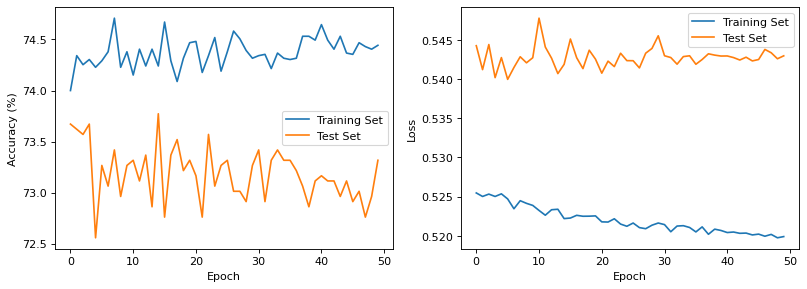

0.01291549665014884
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.47it/s]


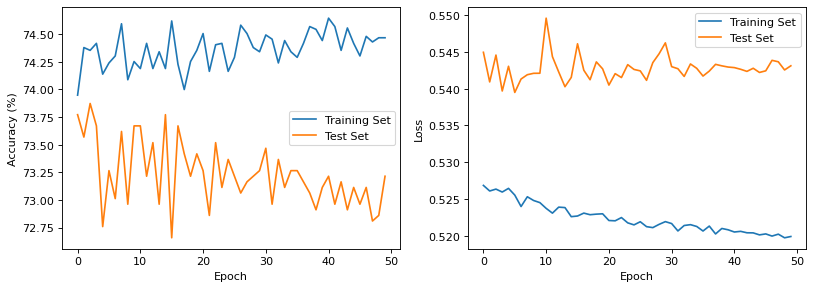

0.021544346900318832
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.51it/s]


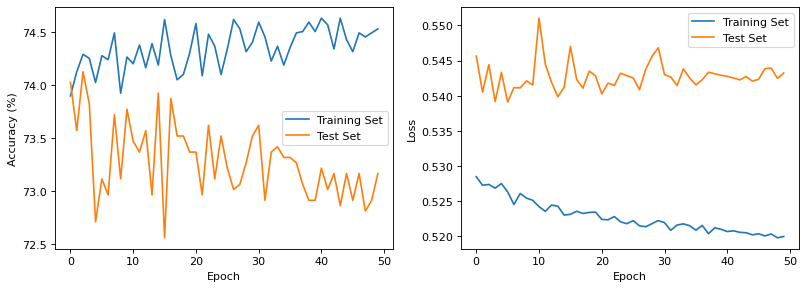

0.03593813663804626
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.26it/s]


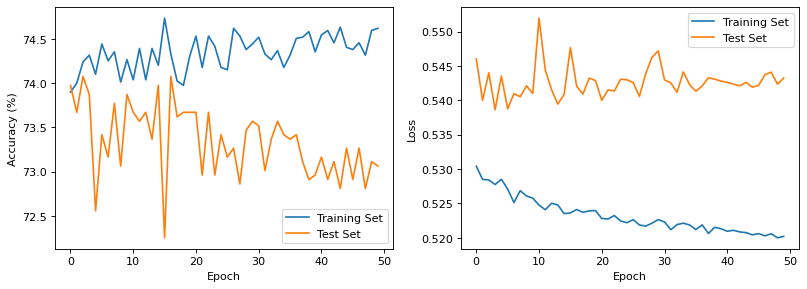

0.05994842503189409
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.01it/s]


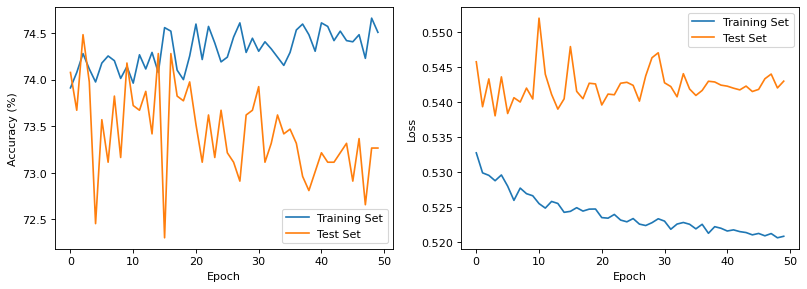

0.1
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.19it/s]


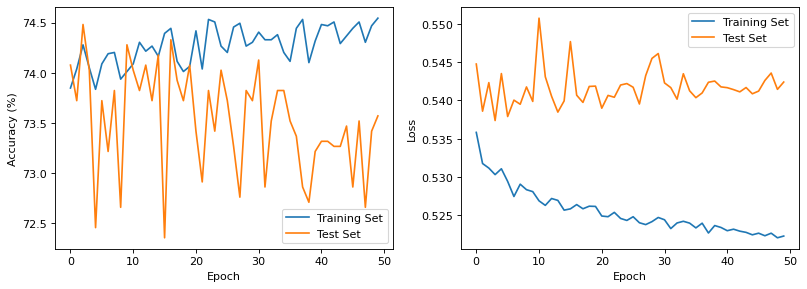

In [30]:
weight_change = np.zeros((3, len(train_seeds), len(thresholds)))  # store parameter difference between models
grad_change = np.zeros((3, len(train_seeds), len(thresholds), n_te))  # store gradient difference between models (test points)
params.weight_decay = wd
for t, train_seed in enumerate(train_seeds):
    for i, act in enumerate(acts):
        b = str(betas[i]) if betas[i] is not None else ''
        base = torch.load(output_dir+f'/base_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy')
        b_grads = np.load(output_dir+f'/base_grads_{acts[i]+b}_wd{wd}_train_seed{train_seed}.npy')
        params.activation = activations[i]

        for j, threshold in enumerate(thresholds):
            print(threshold)
            model, acc_te2, acc_tr2, loss_te2, loss_tr2, pred2, log2, grads, w_change\
                    = fine_tune(base, params, thresh=threshold, train_seed=train_seed,
                                noise_seed=0, epochs=ft_epochs, lr=ft_lr * (j+1))  # adjusts for change in loss due to noise
            weight_change[i,t,j] = w_change[-1]
            grad_change[i,t,j] = np.linalg.norm(b_grads-np.array(grads), axis=1)
np.save(output_dir+'/weight_change_curvature.npy', weight_change)
np.save(output_dir+'/grad_change_curvature.npy', grad_change)

# Curvature (Plot Results)

#### (no error bars due to only one training seed)

In [67]:
from plots import weight_grad_plot

In [68]:
weight_change_curvature = np.load(output_dir+'/weight_change_curvature.npy')
grad_change_curvature = np.load(output_dir+'/grad_change_curvature.npy')

In [69]:
ylabs = ['$||\\theta_1-\\theta_2||_2$' , '$||g_1-g_2||_2$']
labs = ['Relu', 'Softplus (β=5)', f'Softplus (β=2)']
labs

['Relu', 'Softplus (β=5)', 'Softplus (β=2)']

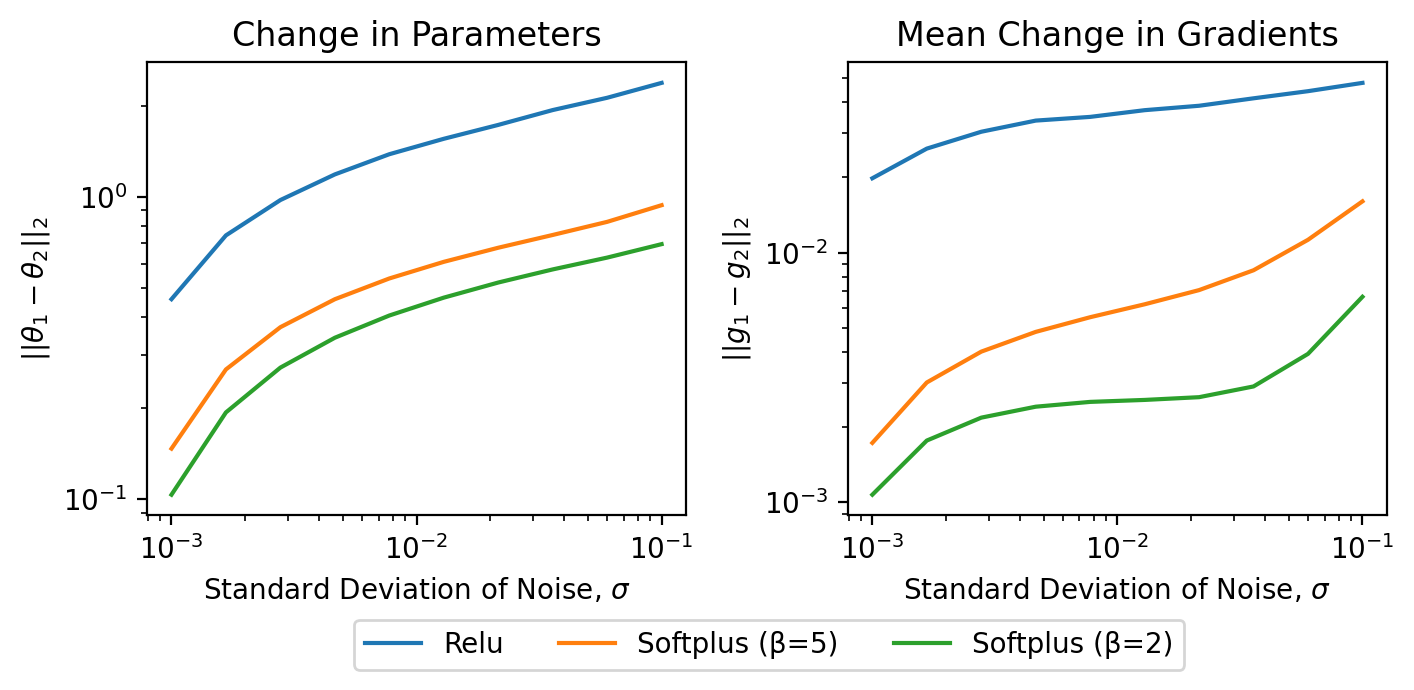

In [70]:
weight_grad_plot(thresholds, weight_change_curvature, grad_change_curvature, labs, qs=[0.25, 0.5, 0.75])

# Weight Decay (Train Base Models)

In [35]:
wds = [0, 0.005, 0.01]  # do not need to include 0.001 as it has already been trialled
act = 'relu'
activation = nn.ReLU()

In [40]:
step_size = 100
gamma = 0.95
base_epochs = 500
lr = 0.5
lr * gamma ** (base_epochs//step_size)

0.3868904687499999

In [41]:
train_seeds = range(1)

Weight Decay = 0
Training with Seed 0


100%|█████████████████████████████████████████| 500/500 [01:50<00:00,  4.54it/s]


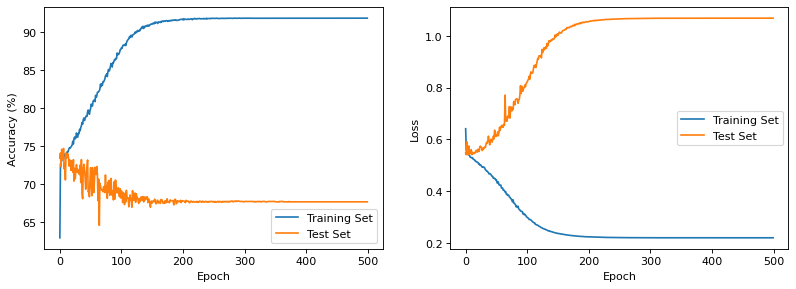

Weight Decay = 0.005
Training with Seed 0


100%|█████████████████████████████████████████| 500/500 [01:49<00:00,  4.55it/s]


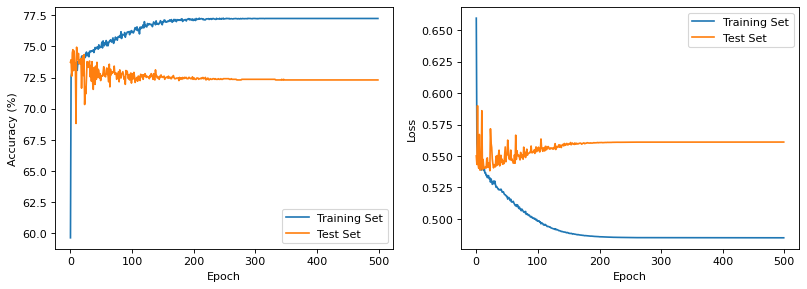

Weight Decay = 0.01
Training with Seed 0


100%|█████████████████████████████████████████| 500/500 [01:50<00:00,  4.54it/s]


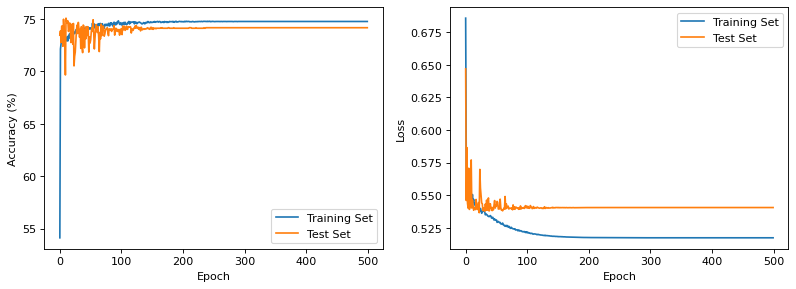

In [42]:
for train_seed in train_seeds:
    for i, wd in enumerate(wds):
        print(f'Weight Decay = {wd}')
        base, acc_te, acc_tr, loss_te, loss_tr, pred, log, b_grads, params\
                    = train_base(weight_decay=wd, train_seed=train_seed, epochs=base_epochs,
                                 lr=lr, activation=activation,
                                 step_size=step_size, gamma=gamma)
        torch.save(base, output_dir+f'/base_{act}_wd{wd}_train_seed{train_seed}.npy')
        np.save(output_dir+f'/base_grads_{act}_wd{wd}_train_seed{train_seed}.npy', b_grads)
        np.save(output_dir+f'/base_loss_te_{act}_wd{wd}_train_seed{train_seed}.npy', loss_te)
        np.save(output_dir+f'/base_loss_tr_{act}_wd{wd}_train_seed{train_seed}.npy', loss_tr)

# Weight Decay (Fine-Tune Models under Dataset Shift - Synthetic Noise)

In [43]:
wds = [0, 0.001, 0.005, 0.01]  # include 0.001 as we will compute gradient/parameter comparisons
act = 'relu'
activation = nn.ReLU()
params.activation = activation

In [44]:
# Standard deviations for synthetic noise
thresholds = np.logspace(-3, -1, 10)
thresholds

array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])

In [45]:
ft_epochs = 50
ft_lr = 0.01

Weight Decay = 0
0.001
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]


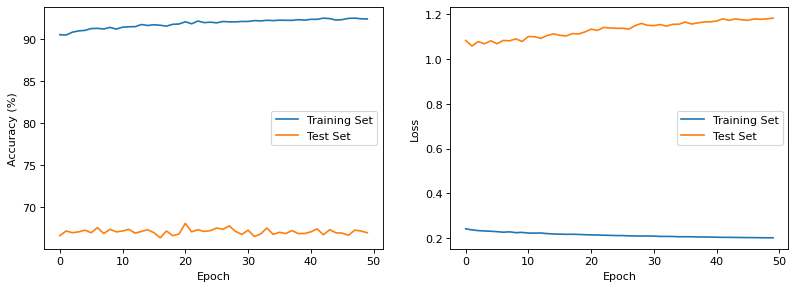

Weight Decay = 0
0.0016681005372000592
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.58it/s]


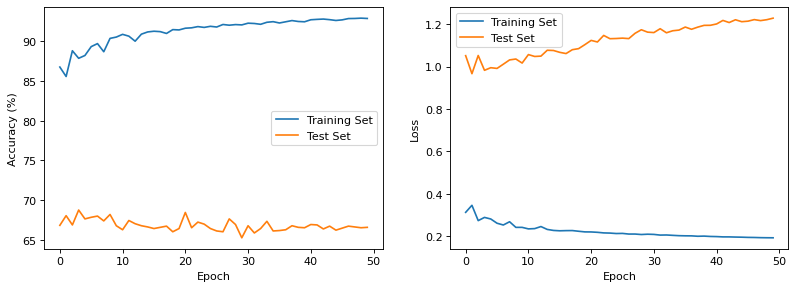

Weight Decay = 0
0.0027825594022071257
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]


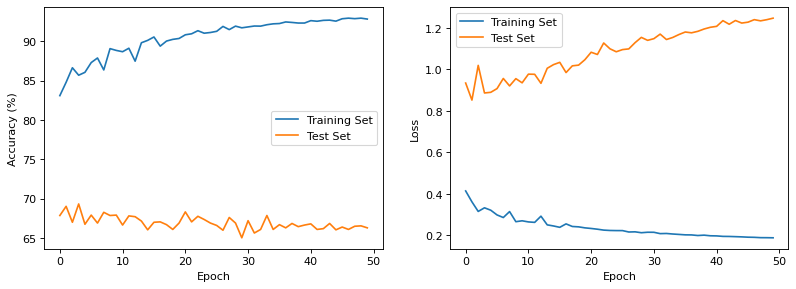

Weight Decay = 0
0.004641588833612777
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.32it/s]


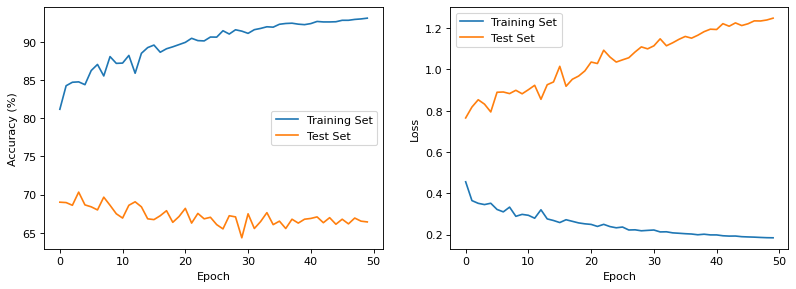

Weight Decay = 0
0.007742636826811269
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.68it/s]


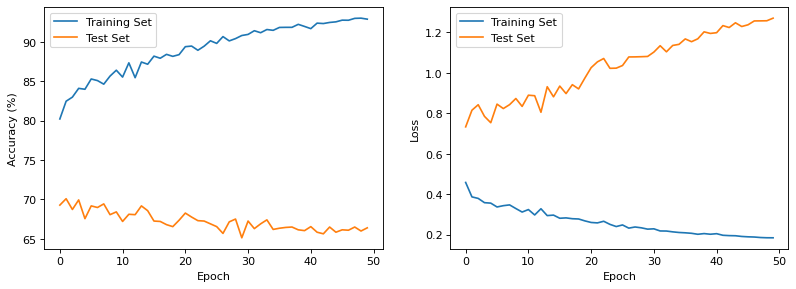

Weight Decay = 0
0.01291549665014884
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.62it/s]


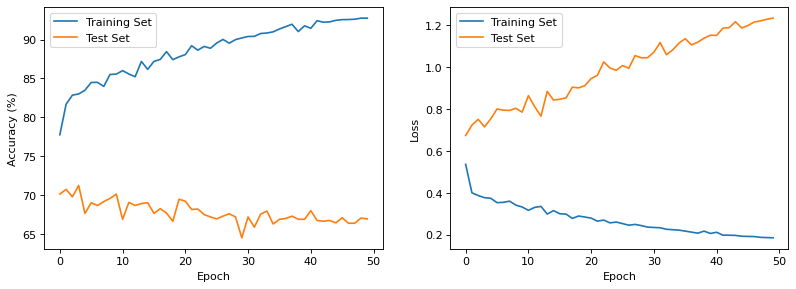

Weight Decay = 0
0.021544346900318832
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.72it/s]


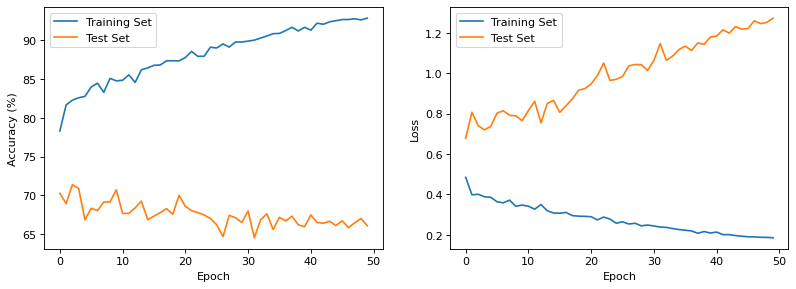

Weight Decay = 0
0.03593813663804626
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.71it/s]


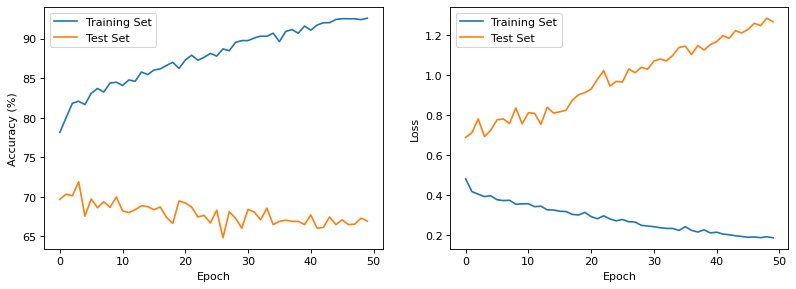

Weight Decay = 0
0.05994842503189409
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.53it/s]


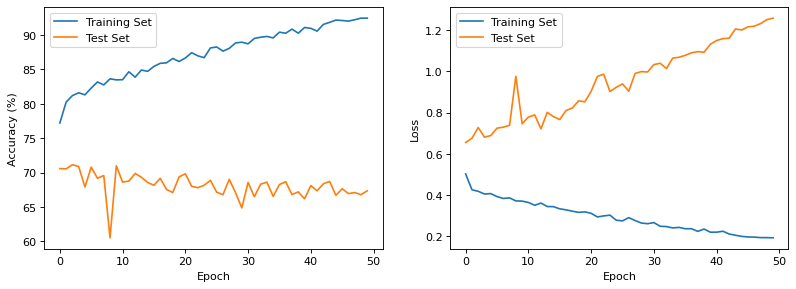

Weight Decay = 0
0.1
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.40it/s]


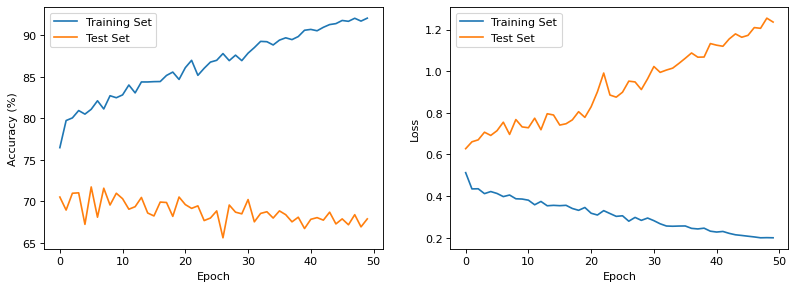

Weight Decay = 0.001
0.001
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.41it/s]


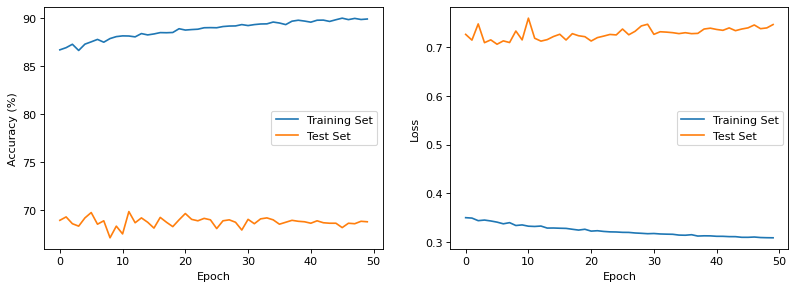

Weight Decay = 0.001
0.0016681005372000592
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.73it/s]


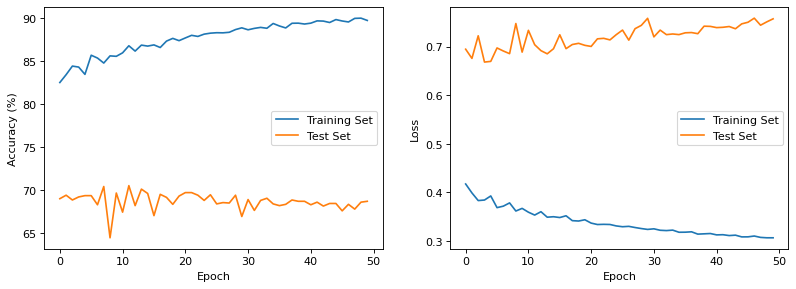

Weight Decay = 0.001
0.0027825594022071257
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.71it/s]


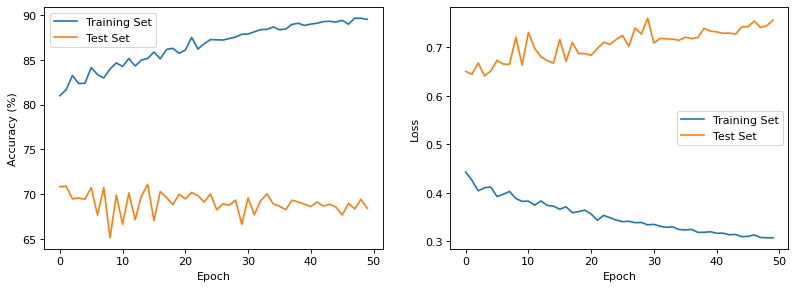

Weight Decay = 0.001
0.004641588833612777
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.55it/s]


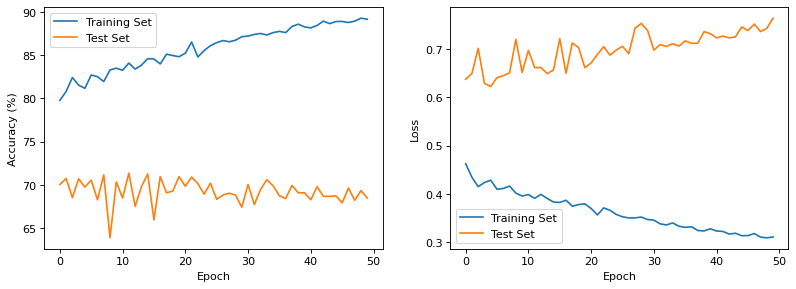

Weight Decay = 0.001
0.007742636826811269
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.68it/s]


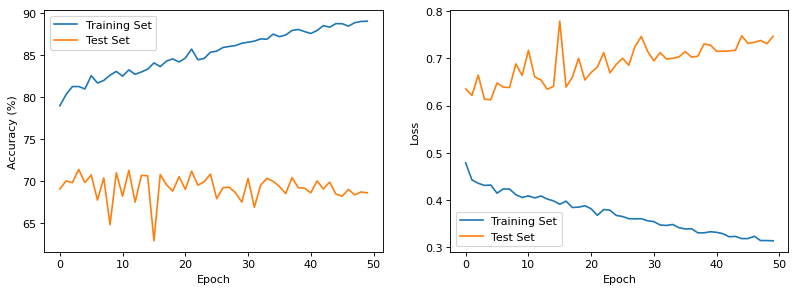

Weight Decay = 0.001
0.01291549665014884
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.35it/s]


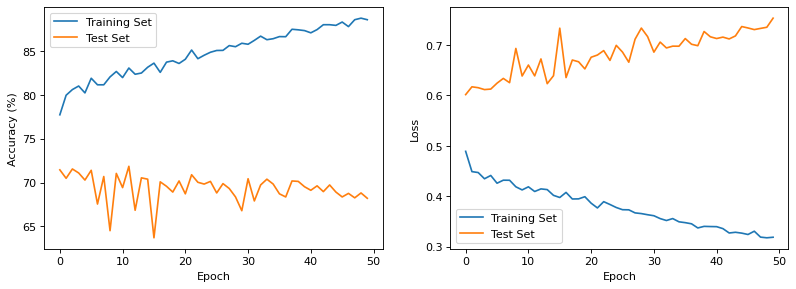

Weight Decay = 0.001
0.021544346900318832
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.63it/s]


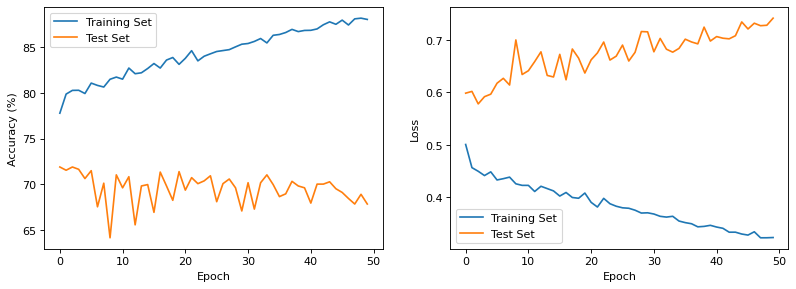

Weight Decay = 0.001
0.03593813663804626
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.26it/s]


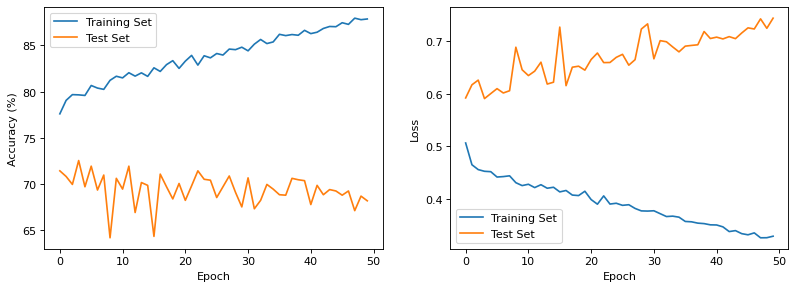

Weight Decay = 0.001
0.05994842503189409
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.45it/s]


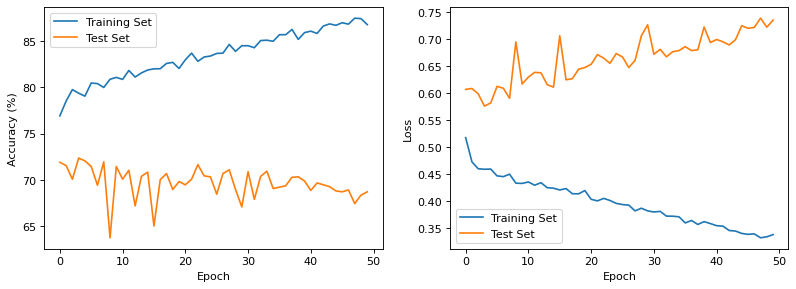

Weight Decay = 0.001
0.1
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.50it/s]


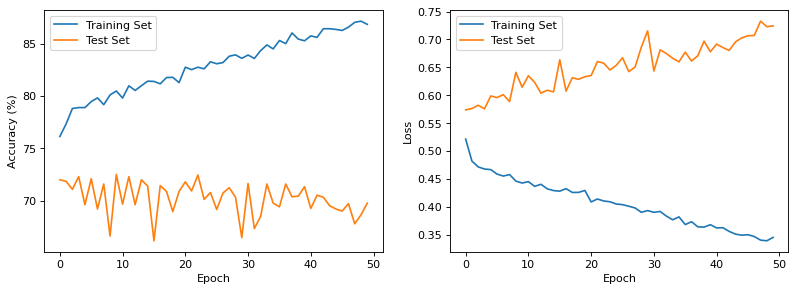

Weight Decay = 0.005
0.001
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.46it/s]


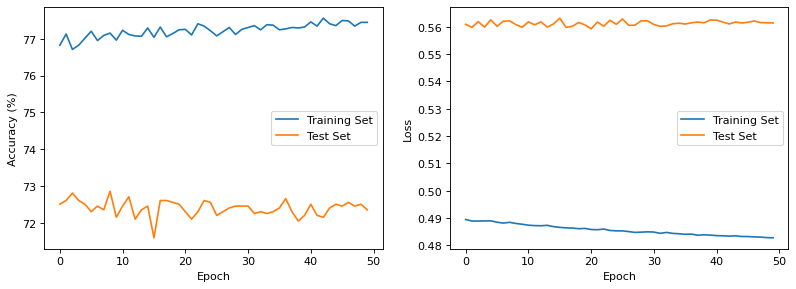

Weight Decay = 0.005
0.0016681005372000592
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.34it/s]


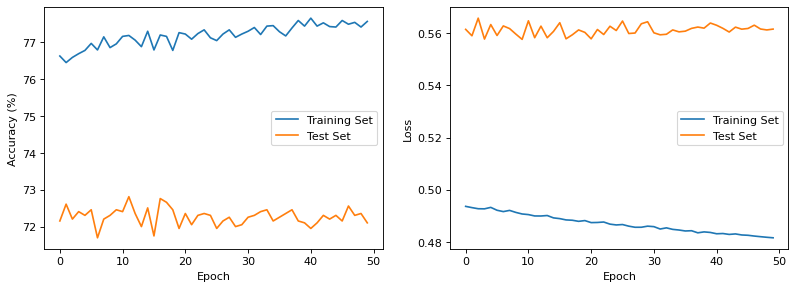

Weight Decay = 0.005
0.0027825594022071257
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.65it/s]


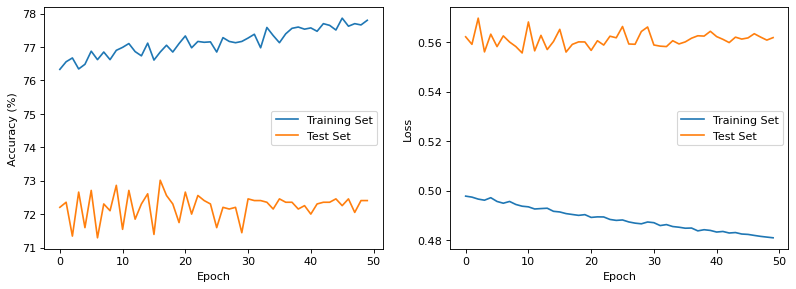

Weight Decay = 0.005
0.004641588833612777
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]


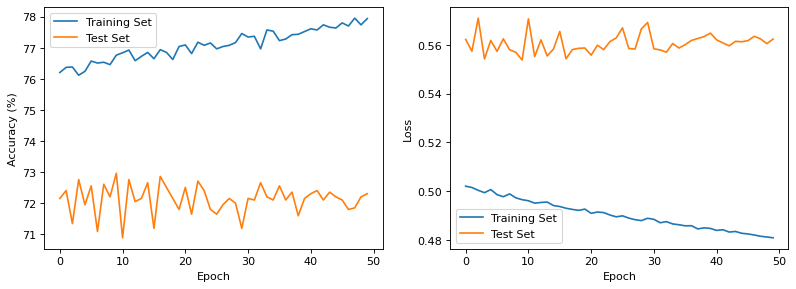

Weight Decay = 0.005
0.007742636826811269
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


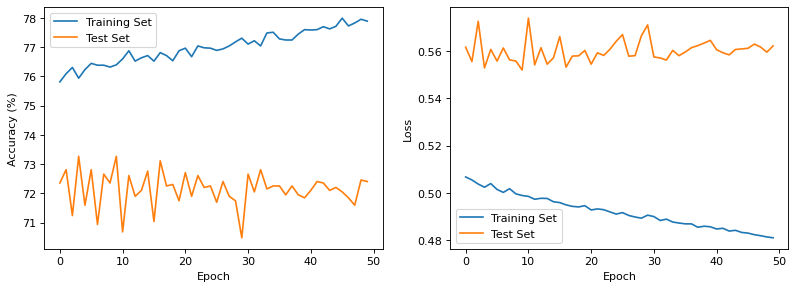

Weight Decay = 0.005
0.01291549665014884
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.65it/s]


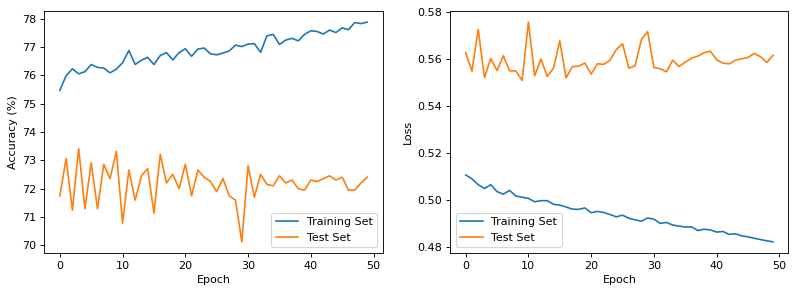

Weight Decay = 0.005
0.021544346900318832
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]


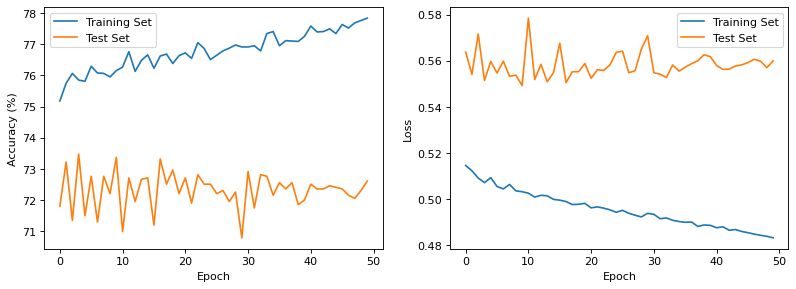

Weight Decay = 0.005
0.03593813663804626
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.59it/s]


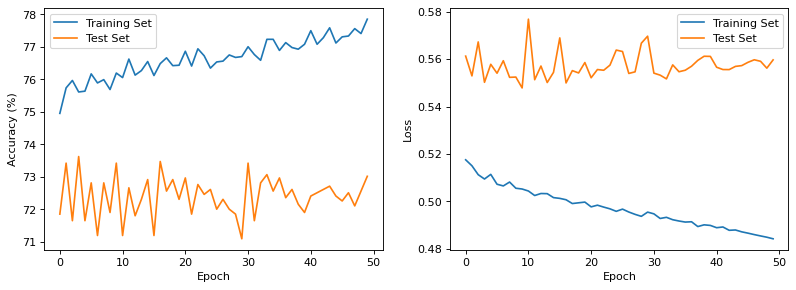

Weight Decay = 0.005
0.05994842503189409
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.61it/s]


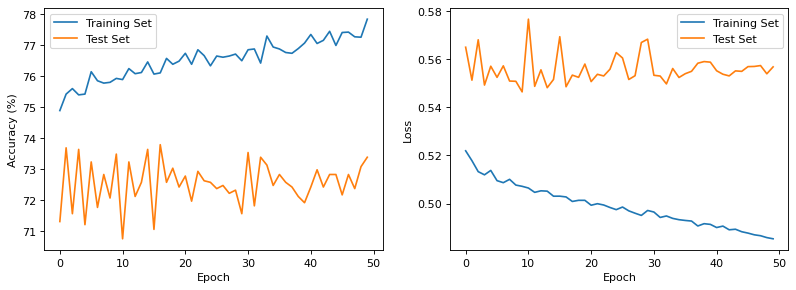

Weight Decay = 0.005
0.1
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.54it/s]


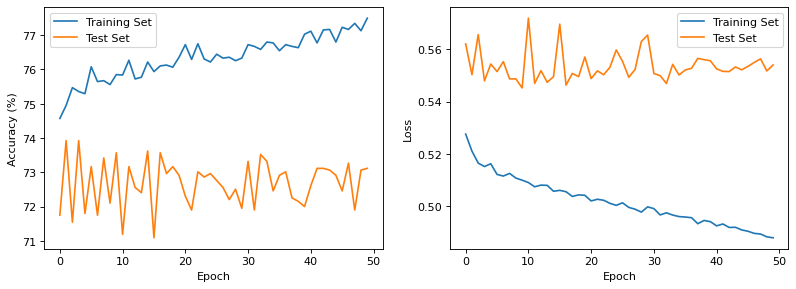

Weight Decay = 0.01
0.001
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]


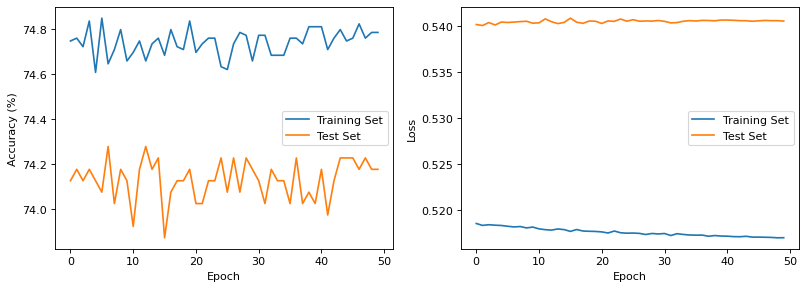

Weight Decay = 0.01
0.0016681005372000592
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]


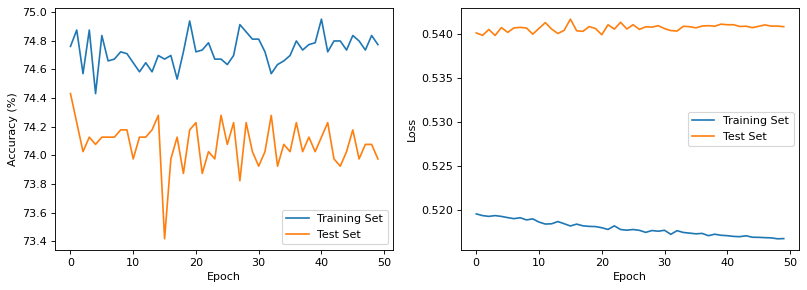

Weight Decay = 0.01
0.0027825594022071257
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.60it/s]


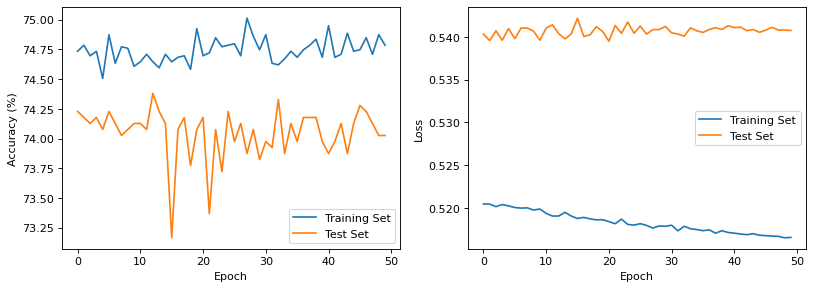

Weight Decay = 0.01
0.004641588833612777
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.62it/s]


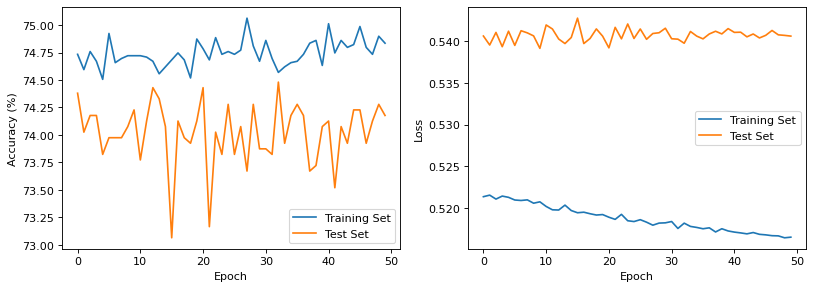

Weight Decay = 0.01
0.007742636826811269
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.66it/s]


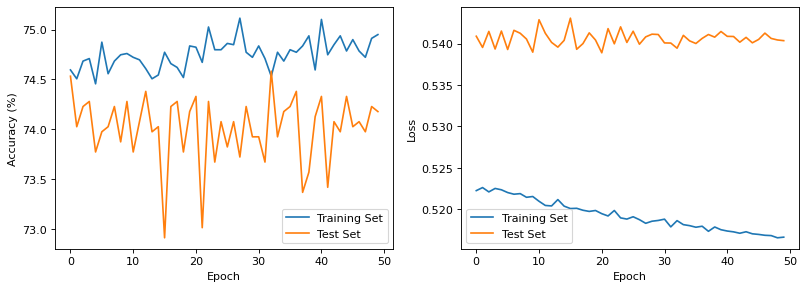

Weight Decay = 0.01
0.01291549665014884
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.64it/s]


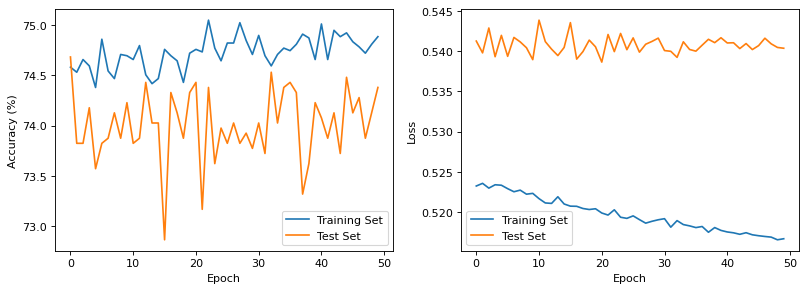

Weight Decay = 0.01
0.021544346900318832
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.56it/s]


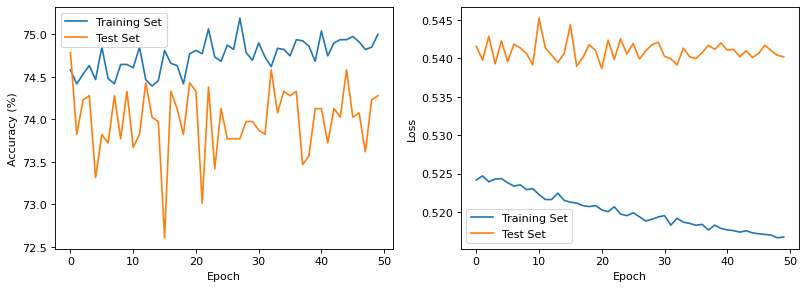

Weight Decay = 0.01
0.03593813663804626
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.61it/s]


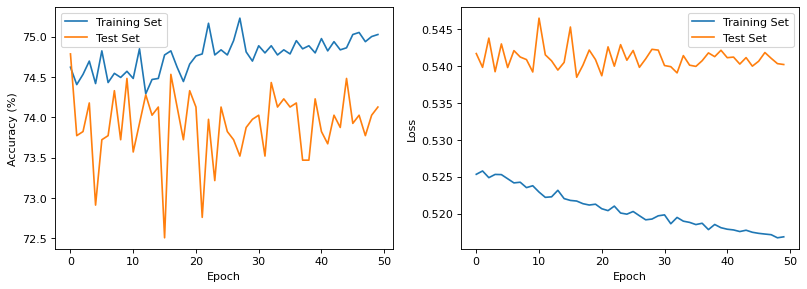

Weight Decay = 0.01
0.05994842503189409
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.61it/s]


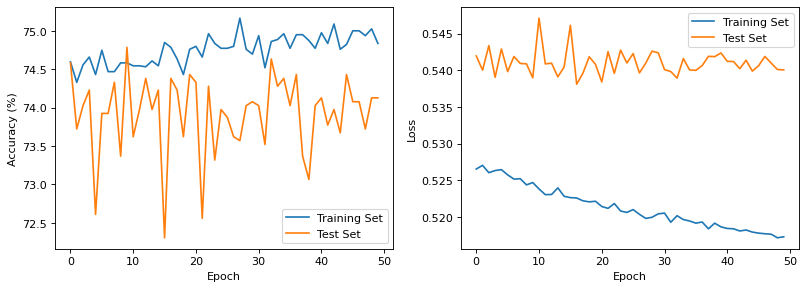

Weight Decay = 0.01
0.1
Training with Seed 0


100%|███████████████████████████████████████████| 50/50 [00:11<00:00,  4.45it/s]


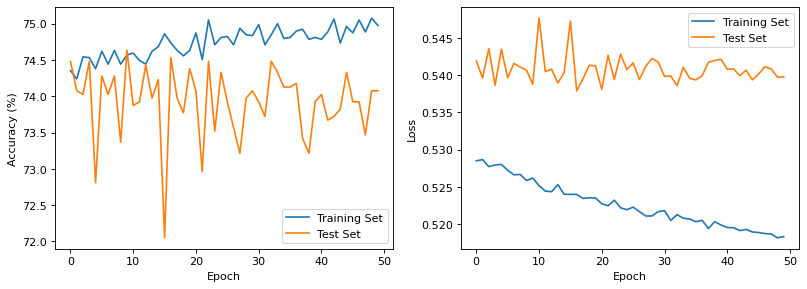

In [46]:
weight_change = np.zeros((len(wds), len(train_seeds), len(thresholds)))
grad_change = np.zeros((len(wds), len(train_seeds), len(thresholds), n_te))
for t, train_seed in enumerate(train_seeds):
    for i, wd in enumerate(wds):
        params.weight_decay = wd
        base = torch.load(output_dir+f'/base_{act}_wd{wd}_train_seed{train_seed}.npy')
        b_grads = np.load(output_dir+f'/base_grads_{act}_wd{wd}_train_seed{train_seed}.npy')

        for j, threshold in enumerate(thresholds):
            print(f'Weight Decay = {wd}')
            print(threshold)
            model, acc_te2, acc_tr2, loss_te2, loss_tr2, pred2, log2, grads, w_change\
                    = fine_tune(base, params, thresh=threshold, train_seed=train_seed,
                                noise_seed=0, epochs=ft_epochs, lr=ft_lr * (j+1))
            weight_change[i,t,j] = w_change[-1]
            grad_change[i,t,j] = np.linalg.norm(b_grads-np.array(grads), axis=1)
np.save(output_dir+'/weight_change_wd.npy', weight_change)
np.save(output_dir+'/grad_change_wd.npy', grad_change)

In [49]:
weight_change_wd = np.load(output_dir+'/weight_change_wd.npy')
grad_change_wd = np.load(output_dir+'/grad_change_wd.npy')

# Weight Decay (Plot Results)

#### (no error bars due to only one training seed)

In [60]:
from plots import weight_grad_plot

In [65]:
ylabs = ['$||\\theta_1-\\theta_2||_2$' , '$||g_1-g_2||_2$']
labs = [f'$\gamma={wd}$' for wd in wds]
labs

['$\\gamma=0$', '$\\gamma=0.001$', '$\\gamma=0.005$', '$\\gamma=0.01$']

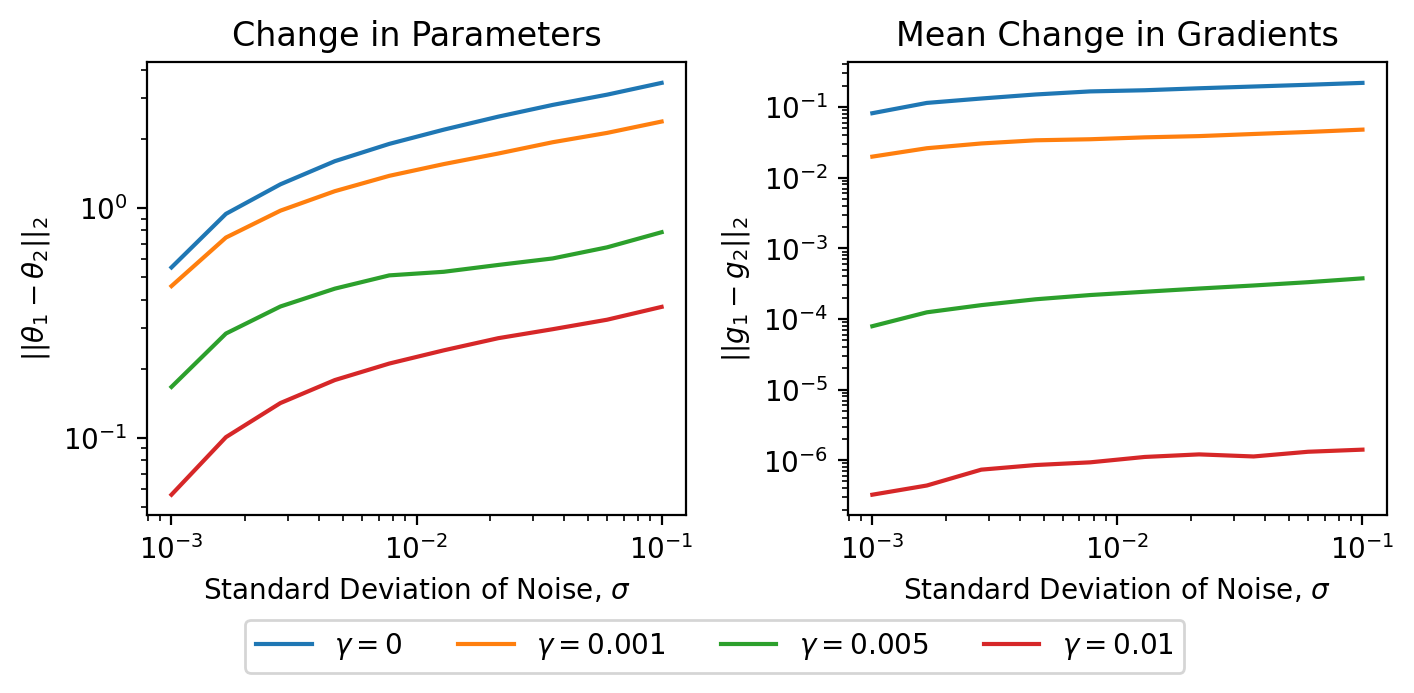

In [66]:
weight_grad_plot(thresholds, weight_change_wd, grad_change_wd, labs, qs=[0.25, 0.5, 0.75])